In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import gc
import random
import itertools
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch
import tokenizers
import transformers
from transformers import AutoTokenizer, EncoderDecoderModel, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
import datasets
from datasets import load_dataset, load_metric
import sentencepiece
import argparse
from datasets.utils.logging import disable_progress_bar
from rdkit import Chem
import rdkit
disable_progress_bar()

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--input_data", type=str, required=False)
#     parser.add_argument("--dataset_name", type=str, required=False)
    parser.add_argument("--model_name_or_path", type=str, required=True)
    parser.add_argument("--model", type=str, required=True)
    parser.add_argument("--debug", action='store_true', default=False, required=False)
    parser.add_argument("--num_beams", type=int, default=5, required=False)
    parser.add_argument("--num_return_sequences", type=int, default=5, required=False)
    parser.add_argument("--seed", type=int, default=42, required=False)

    return parser.parse_args()
    
# CFG = parse_args()

class CFG:
    model = 't5'
    dataset_path = '../../multi-input-valid.csv'
    model_name_or_path = '/data2/sagawa/tcrp-multiinput-archive/10-epoch-archive2/t5/checkpoint-2721180'
    num_beams = 5
    num_return_sequences = 5
    debug = True
    seed = 42
    

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(seed=CFG.seed)  
    

    
dataset = pd.read_csv(CFG.dataset_path)



tokenizer = AutoTokenizer.from_pretrained(CFG.model_name_or_path, return_tensors='pt')
    
if CFG.model == 't5':
    model = AutoModelForSeq2SeqLM.from_pretrained(CFG.model_name_or_path).to(device)
elif CFG.model == 'deberta':
    model = EncoderDecoderModel.from_pretrained(CFG.model_name_or_path).to(device)


In [3]:
import pandas as pd
import numpy as np
# df = pd.DataFrame(np.array([[0 for i in range(10000)] for j in range(10000)]))
df.dtypes

0       int64
1       int64
2       int64
3       int64
4       int64
        ...  
9995    int64
9996    int64
9997    int64
9998    int64
9999    int64
Length: 10000, dtype: object

In [6]:
df = df.astype(np.float64)
df.to_csv('float.csv', index=False)

In [90]:
tf = [False if i.startswith('REACTANT: CATALYST: REAGENT: SOLVENT: NoData:') else True for i in dataset['input']]
print(sum(tf)/len(tf))

0.7870737859624984


In [44]:
dataset = dataset[:100]
dataset

,input,PRODUCT
0,REACTANT:NCCO.O=C1COCC(=O)O1CATALYST: REAGENT:...,CC(C)(C)[C@H](N)C(=O)O.CN(C)CC(=O)O.NCC(=O)O.N...
1,REACTANT: CATALYST: REAGENT: SOLVENT: NoData:C...,CC(C)(C)OC(=O)NC1(C2CCNC2)CCC1
2,REACTANT:C1CCNCC1.Cl.NS(=O)(=O)c1cc(C(=O)O)cc(...,CCS(=O)(=O)OCCBr
3,REACTANT: CATALYST: REAGENT: SOLVENT: NoData:C...,CCCC(Cc1ccc(OCCN2CCCCCC2)cc1)(C(=O)O)S(=O)(=O)...
4,REACTANT:CCO.Cc1cc(C(=O)NC(CC(=O)O)c2ccc(NC(=O...,CCCCCCCCCCCC(=O)N1CCC[C@H]1C(=O)O
...,...,...
95,REACTANT:Cc1c(C)c(S(=O)(=O)NCC(=O)NC(Cc2ccc3c(...,Cc1ccc(C#CC(C)(C)O)cc1F
96,REACTANT:CCN(CC)CC.COc1ccc(OC)c2c1CCN(c1nc(Cl)...,CC(C)(C)[C@H](N)C(=O)O.CN(C)CC(=O)O.NCC(=O)O.N...
97,REACTANT:Br.COc1cc(C#N)cc(OC)c1-c1csc2c(N(CC3C...,O=C(O)c1cccc(Cl)c1
98,REACTANT: CATALYST: REAGENT: SOLVENT: NoData:C...,C=CCC(N)(CC)CC=C


In [45]:
dataset['input'][0]

'REACTANT:NCCO.O=C1COCC(=O)O1CATALYST: REAGENT: SOLVENT:c1ccncc1NoData: '

In [1]:
REACTANT:CCOC=C1C[C@H]2[C@@H]3CCc4cc(OCc5ccccc5)ccc4[C@H]3CC[C@]2(C)[C@H]1OC(C)=O.O=C([O-])O.[Na+]CATALYST:Cl.O

89

In [54]:
# sequences_scores: cumulative log probabilities of each beams

# input_data = 'REACTANT:NCCO.O=C1COCC(=O)O1CATALYST: REAGENT: SOLVENT:c1ccncc1NoData: '
input_data = '../../multi-input-valid.csv'


if 'csv' not in input_data:
    input_compound = input_data
    min_length = min(input_compound.find('CATALYST') - input_compound.find(':') - 10, 0)
    inp = tokenizer(input_compound, return_tensors='pt').to(device)
    output = model.generate(**inp, num_beams=CFG.num_beams, num_return_sequences=CFG.num_return_sequences, return_dict_in_generate=True, output_scores=True)
    scores = output['sequences_scores'].tolist()
    output = [tokenizer.decode(i, skip_special_tokens=True).replace('. ', '.').rstrip('.') for i in output['sequences']]
    for ith, out in enumerate(output):
        mol = Chem.MolFromSmiles(out.rstrip('.'))
        if type(mol) == rdkit.Chem.rdchem.Mol:
            output.append(out.rstrip('.'))
            scores.append(scores[ith])
            break
    if type(mol) == None:
        output.append(None)
        scores.append(None)
    output += scores
    output = [input_compound] + output
    output_df = pd.DataFrame(np.array(output).reshape(1, -1), columns=['input'] + [f'{i}th' for i in range(CFG.num_beams)] + ['valid compound'] + [f'{i}th score' for i in range(CFG.num_beams)] + ['valid compound score'])
    output_df.to_csv('output.csv', index=False)

elif 'csv' in input_data:
    input_data = pd.read_csv(input_data)
    input_data = input_data[:100]
    outputs = []
    for idx, row in dataset.iterrows():
        input_compound = row['input']
        min_length = min(input_compound.find('CATALYST') - input_compound.find(':') - 10, 0)################# min_length, max_lengthの調節は要注意
        inp = tokenizer(input_compound, return_tensors='pt').to(device)
        output = model.generate(**inp, num_beams=CFG.num_beams, num_return_sequences=CFG.num_return_sequences, return_dict_in_generate=True, output_scores=True)
        scores = output['sequences_scores'].tolist()
        output = [tokenizer.decode(i, skip_special_tokens=True).replace('. ', '.').rstrip('.') for i in output['sequences']]
        for ith, out in enumerate(output):
            mol = Chem.MolFromSmiles(out.rstrip('.'))
            if type(mol) == rdkit.Chem.rdchem.Mol:
                output.append(mol)
                scores.append(scores[ith])
                break
        if type(mol) == None:
            output.append(None)
            scores.append(None)
        output += scores
        output = [input_compound] + output
        outputs.append(output)
    output_df = pd.DataFrame(outputs, columns=['input'] + [f'{i}th' for i in range(CFG.num_beams)] + ['valid compound'] + [f'{i}th score' for i in range(CFG.num_beams)] + ['valid compound score'])
    output_df.to_csv('output.csv', index=False)


[11:06:29] SMILES Parse Error: syntax error while parsing: COC(=O)CN1CCN(CC(=O)OC(
[11:06:29] SMILES Parse Error: Failed parsing SMILES 'COC(=O)CN1CCN(CC(=O)OC(' for input: 'COC(=O)CN1CCN(CC(=O)OC('
[11:06:29] SMILES Parse Error: extra open parentheses for input: 'CC(C)(C)[C@H](N)C(=O'
[11:06:30] SMILES Parse Error: extra open parentheses for input: 'CC(C)(C)OC(=O)NC1(C2'
[11:06:30] SMILES Parse Error: extra open parentheses for input: 'CC(C)(C)OC(=O)C1(C2CCN'
[11:06:30] SMILES Parse Error: syntax error while parsing: CC(C)(C)OC(=O)[NH+](
[11:06:30] SMILES Parse Error: Failed parsing SMILES 'CC(C)(C)OC(=O)[NH+](' for input: 'CC(C)(C)OC(=O)[NH+]('
[11:06:30] SMILES Parse Error: unclosed ring for input: 'Cl.CC(C)(C)OC(=O)NC1'
[11:06:31] SMILES Parse Error: syntax error while parsing: CCCC(Cc1ccc(OCCN2CCCCCC2)cc1)(
[11:06:31] SMILES Parse Error: Failed parsing SMILES 'CCCC(Cc1ccc(OCCN2CCCCCC2)cc1)(' for input: 'CCCC(Cc1ccc(OCCN2CCCCCC2)cc1)('
[11:06:31] SMILES Parse Error: extra open pare

[11:06:44] SMILES Parse Error: unclosed ring for input: 'NN=C(C=Cc1ccccc1)c1ccccc'
[11:06:44] SMILES Parse Error: extra open parentheses for input: 'CC(C)(C)[C@H](N)C(=O'
[11:06:44] SMILES Parse Error: extra open parentheses for input: 'CCOC(=O)c1cccc(-c2cn(-c3ccc'
[11:06:46] SMILES Parse Error: syntax error while parsing: Cn1nnnc1-c1cc(Br)cc([N
[11:06:46] SMILES Parse Error: Failed parsing SMILES 'Cn1nnnc1-c1cc(Br)cc([N' for input: 'Cn1nnnc1-c1cc(Br)cc([N'
[11:06:47] SMILES Parse Error: extra open parentheses for input: 'Cl.Cl.Cl.NCCCC[C@H](N'
[11:06:47] SMILES Parse Error: extra open parentheses for input: 'O=[N+]([O-])C(F)(CO'
[11:06:47] SMILES Parse Error: extra open parentheses for input: 'O=C(O)c1cc(-n2c(=O)'
[11:06:47] SMILES Parse Error: syntax error while parsing: CC(C)(O)C(F)(F)C(F)(
[11:06:47] SMILES Parse Error: Failed parsing SMILES 'CC(C)(O)C(F)(F)C(F)(' for input: 'CC(C)(O)C(F)(F)C(F)('
[11:06:47] SMILES Parse Error: syntax error while parsing: CC(O)CC(=O)[O-].O=C(
[11:0

[11:07:01] SMILES Parse Error: extra open parentheses for input: 'O=[N+]([O-])N=C1N(C'
[11:07:01] SMILES Parse Error: unclosed ring for input: 'CC(C)CN=C1C(c2ccccc2)=C'
[11:07:02] SMILES Parse Error: syntax error while parsing: COC(=O)CN1CCN(CC(=O)OC(
[11:07:02] SMILES Parse Error: Failed parsing SMILES 'COC(=O)CN1CCN(CC(=O)OC(' for input: 'COC(=O)CN1CCN(CC(=O)OC('
[11:07:02] SMILES Parse Error: syntax error while parsing: COC(=O)CN1CCN(CC(=O)OC(
[11:07:02] SMILES Parse Error: Failed parsing SMILES 'COC(=O)CN1CCN(CC(=O)OC(' for input: 'COC(=O)CN1CCN(CC(=O)OC('
[11:07:02] SMILES Parse Error: unclosed ring for input: 'NN=C(C=Cc1ccccc1)c1ccccc'
[11:07:02] SMILES Parse Error: syntax error while parsing: CC#CN1C(=O)C(C)Oc2ccc(
[11:07:02] SMILES Parse Error: Failed parsing SMILES 'CC#CN1C(=O)C(C)Oc2ccc(' for input: 'CC#CN1C(=O)C(C)Oc2ccc('
[11:07:02] SMILES Parse Error: extra open parentheses for input: 'CCc1c(Cc2[nH]c(C(=O)'
[11:07:03] SMILES Parse Error: extra open parentheses for input: '

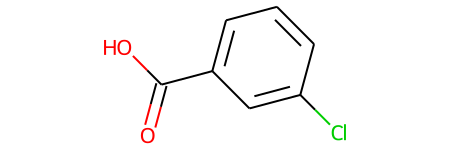

In [82]:
i = 10
output_df['valid compound'][i]

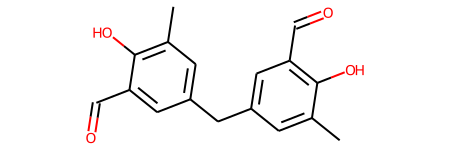

In [83]:
original['valid compound'][i]

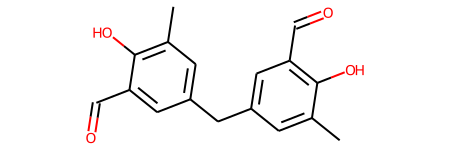

In [84]:
Chem.MolFromSmiles(dataset['PRODUCT'][i])

In [107]:
dataset = pd.concat([dataset, output_df], axis=1)

In [108]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools
# dataset.to_excel("aryl_halides.xlsx",index=False)
dataset.to_csv('../../generated3.csv', index=False)

[16:37:50] unsupported number of radical electrons 4
[16:37:50] unsupported number of radical electrons 4


In [39]:
PandasTools.WriteSDF(dataset.dropna(axis=0), 'sample.xls', molColName='most_probable')

In [2]:
dataset = pd.read_csv('../../generated3.csv')
dataset

,input,PRODUCT,0,1,2,3,4,most_probable
0,REACTANT:NCCO.O=C1COCC(=O)O1CATALYST: REAGENT:...,CC(C)(C)[C@H](N)C(=O)O.CN(C)CC(=O)O.NCC(=O)O.N...,CC1(C)COCN1CC(C)(C)[N+](=O)[O-],C=CCC1(CC)C(=O)NC(=O)NC1=O,CC1(C)COCN1CC(C)(C)[N+](=O)[O-].O=S(=O)([O-])[...,CC1(C)COCN1CC(C)(C)[N+](=O)[O-].O=C([O-])[O-]....,CC1(C)COCN1CC(C)(C)[N+](=O)[O-].O=C([O-])CC(=O)O,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,REACTANT: CATALYST: REAGENT: SOLVENT: NoData:C...,CC(C)(C)OC(=O)NC1(C2CCNC2)CCC1,CC(C)(C)OC(=O)NC1(C2CCNC2)CCC1,CC(C)(C)OC(=O)NC1(C2CC[NH2+]C2)CCC1.[Br-],CC(C)(C)OC(=O)[NH+]([O-])C1(C2CCNC2)CCC1,CC(C)(C)OC(=O)NC1(C2CC[NH2+]C2)CCC1.[Cl-],CC(C)(C)OC(=O)NC1(C2CC[NH2+]C2)CCC1.[I-],"<img data-content=""rdkit/molecule"" src=""data:i..."
2,REACTANT:C1CCNCC1.Cl.NS(=O)(=O)c1cc(C(=O)O)cc(...,CCS(=O)(=O)OCCBr,CC1(C)COCN1CC(C)(C)[N+](=O)[O-].O=S(=O)([O-])[...,CC1(C)COCN1CC(C)(C)[N+](=O)[O-].O=C([O-])[O-]....,CC1(C)COCN1CC(C)(C)[N+](=O)[O-].O=C([O-])[O-]c...,CC1(C)COCN1CC(C)(C)[N+](=O)[O-].O=S(=O)([O-])[...,CC1(C)COCN1CC(C)(C)[N+](=O)[O-].O=C([O-])[O-]c...,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,REACTANT: CATALYST: REAGENT: SOLVENT: NoData:C...,CCCC(Cc1ccc(OCCN2CCCCCC2)cc1)(C(=O)O)S(=O)(=O)...,CCCC(Cc1ccc(OCCN2CCCCCC2)cc1)(C(=O)O)S(=O)(=O)...,CCCCC(Cc1ccc(OCCN2CCCCCC2)cc1)(C(=O)O)S(=O)(=O...,CCCC(Cc1ccc(OCCN2CCCCCC2)cc1)(C(=O)[O-])S(=O)(...,CCCC(Cc1ccc(OCCN2CCCCCC2)cc1)(C(=O)O)S(=O)(=O)...,CCCC(Cc1ccc(OCCN2CCCCCC2)cc1)S(=O)(=O)c1ccc(OC...,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,REACTANT:CCO.Cc1cc(C(=O)NC(CC(=O)O)c2ccc(NC(=O...,CCCCCCCCCCCC(=O)N1CCC[C@H]1C(=O)O,CC(C)(C)[C@H](N)C(=O)O.CN(C)CC(=O)O.NCC(=O)O.N...,CC(C)(C)[C@H](N)C(=O)O.CN(C)CC(=O)O.NCC(=O)O.N...,CC(C)(C)[C@H](N)C(=O)O.CN(C)CC(=O)O.NCC(=O)O.N...,CC(C)(C)[C@H](N)C(=O)O.CN(C)CC(=O)O.NCC(=O)O.N...,CC(C)(C)[C@H](N)C(=O)O.CN(C)CC(=O)O.NCC(=O)O.N...,NaN
...,...,...,...,...,...,...,...,...
995,REACTANT:CCCNC(=O)c1ccc(Oc2ccc(Cl)cc2N)cc1.Cc1...,O=S(=O)([O-])[O-].O=S(=O)([O-])[O-].O=S(=O)([O...,O=S(=O)([O-])[O-].O=S(=O)([O-])[O-].O=S(=O)([O...,O=S(=O)([O-])[O-].O=S(=O)([O-])[O-].O=S(=O)([O...,O=S(=O)([O-])[O-].O=S(=O)([O-])[O-].O=S(=O)([O...,O=S(=O)([O-])[O-].O=S(=O)([O-])[O-]CS(=O)(=O)[...,O=S(=O)([O-])[O-].O=S(=O)([O-])[O-].O=S(=O)([O...,"<img data-content=""rdkit/molecule"" src=""data:i..."
996,REACTANT:CN(C)C(=O)Cl.Cl.Fc1ccc(C2=CCNCC2)cc1....,CCCCCCCCCCCCNC(=O)N(C)C[C@H](O)[C@@H](O)[C@H](...,CC(C)(C)[C@H](N)C(=O)O.CN(C)CC(=O)O.NCC(=O)O.N...,CC(C)(C)[C@H](N)C(=O)O.CN(C)CC(=O)O.NCC(=O)O.N...,CC(C)(C)[C@H](N)C(=O)O.CN(C)CC(=O)O.NCC(=O)O.N...,CC(C)(C)[C@H](N)C(=O)O.CN(C)CC(=O)O.NCC(=O)O.N...,CC(C)(C)[C@H](N)C(=O)O.CN(C)CC(=O)O.NCC(=O)O.N...,"<img data-content=""rdkit/molecule"" src=""data:i..."
997,REACTANT:COCOc1cc(C(F)(F)F)ccc1-c1cc(Oc2ccc3cc...,C[C@H](CO)CO[Si](c1ccccc1)(c1ccccc1)C(C)(C)C,C[C@H](CO)CO[S](c1ccccc1)(c1ccccc1)C(C)(C)C.O=...,C[C@H](CO)CO[S](c1ccccc1)(c1ccccc1)C(C)(C)C.O=...,C[C@H](CO)CO[S](c1ccccc1)(c1ccccc1)C(C)(C)C.O=...,CNC(=O)c1ncn2c(C)cc(C)[n+](C)c12c1cc(Br)cnc12....,C[C@H](CO)CO[S](c1ccccc1)(c1ccccc1)C(C)(C)C.O=...,"<img data-content=""rdkit/molecule"" src=""data:i..."
998,REACTANT:C1=COCCC1.CC1(C)C2CCC1(CS(=O)(=O)O)C(...,Cn1nnnc1-c1cc(Br)cc([N+](=O)[O-])c1,CC(C)(C)[C@H](N)C(=O)O.CN(C)CC(=O)O.NCC(=O)O.N...,CC(C)(C)[C@H](N)C(=O)O.CN(C)CC(=O)O.NCC(=O)OC....,CC(C)(C)[C@H](N)C(=O)OC.CN(C)CC(=O)O.NCC(=O)O....,CC(C)(C)[C@H](N)C(=O)O.CN(C)CC(=O)OC.NCC(=O)O....,CC(C)(C)[C@H](N)C(=O)O.CN(C)CC(=O)O.NCC(=O)O.N...,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [3]:
mols = []
for idx, row in dataset.iterrows():
    if type(row['most_probable']) != str:
        mols.append(None)
    else:
        for i in range(5):
            out = row[str(i)]
            mol = Chem.MolFromSmiles(out)
            if type(mol) == rdkit.Chem.rdchem.Mol:
                mols.append(mol)
                break
dataset['most_probable'] = mols

[19:24:50] SMILES Parse Error: unclosed ring for input: 'CCCCOc1cc(N=C2C=CC(Nc3ccc(N(CC)C(C)C)cc3)C(N)=C2C=C2N=C(N)C=C2[C@@H]2CC[C@@]2(C)[C@H]3CC[C@@H]2[C@H](C)CCCC(C)C)cc1'
[19:24:50] SMILES Parse Error: unclosed ring for input: 'CCCCOc1cc(N=C2C=CC(Nc3ccc(N(CC)C(C)C)cc3)C(N)=C2C=C2N=C(N)C=C2[C@@H]2CC[C@@]2(C)[C@H]3CC[C@@H]2[C@H](C)CCCC(C)C)c1'
[19:24:50] Can't kekulize mol.  Unkekulized atoms: 35 36 37 51 74
[19:24:50] Can't kekulize mol.  Unkekulized atoms: 35 36 37 51
[19:24:50] Can't kekulize mol.  Unkekulized atoms: 35 36 37 51 75
[19:24:50] Can't kekulize mol.  Unkekulized atoms: 18 19 20 33 57
[19:24:50] Can't kekulize mol.  Unkekulized atoms: 18 19 20 33 56
[19:24:50] Can't kekulize mol.  Unkekulized atoms: 18 19 20 33 58
[19:24:50] SMILES Parse Error: unclosed ring for input: 'NN=C(C=Cc1ccccc1)c1ccccc1.Cc1cc(Cc2cc(C)c(O)c(C=O)c2)[nH]c(Cc2[nH]c(C(=O)OCc3ccccc3)c(C)c2CCC(=O)OC)c1ccccc1'
[19:24:50] Can't kekulize mol.  Unkekulized atoms: 43 44 45 58 60
[19:24:50] Explicit valence

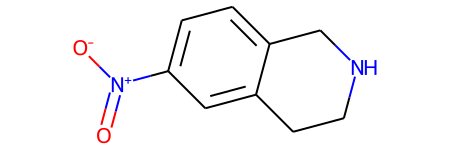

In [49]:
i = 22
dataset['most_probable'][i]

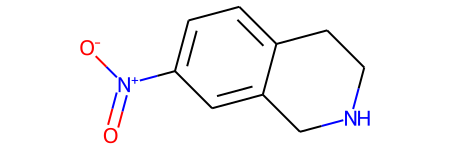

In [50]:
Chem.MolFromSmiles(dataset['PRODUCT'][i])

In [35]:
lens = df['input'].apply(lambda x: len(x))
df = df[lens <= 512]
train, test = train_test_split(df, test_size=int(len(all)*0.1))
train, valid = train_test_split(train, test_size=int(len(all)*0.1))
train.to_csv('multi-input-train.csv', index=False)
valid.to_csv('multi-input-valid.csv', index=False)
test.to_csv('multi-input-test.csv', index=False)

In [10]:
from collections import Counter
counter = Counter()
for l in df['len']:
    counter[l] += 1
counter

Counter({313: 126,
         314: 141,
         339: 36,
         325: 62,
         318: 89,
         298: 268,
         306: 215,
         307: 197,
         312: 97,
         310: 144,
         324: 86,
         315: 93,
         104: 35801,
         111: 33557,
         124: 25655,
         100: 35761,
         107: 35541,
         120: 28068,
         110: 34186,
         117: 31091,
         130: 21377,
         114: 31926,
         121: 27730,
         134: 18516,
         128: 22585,
         141: 14942,
         106: 35725,
         113: 33036,
         126: 24081,
         116: 31744,
         123: 26573,
         136: 17538,
         127: 23670,
         140: 15104,
         147: 11749,
         137: 17120,
         133: 19406,
         143: 13655,
         154: 9148,
         129: 22096,
         149: 11069,
         125: 25371,
         132: 20146,
         145: 12661,
         135: 18132,
         142: 14186,
         155: 8666,
         139: 15577,
         146: 12309,
   

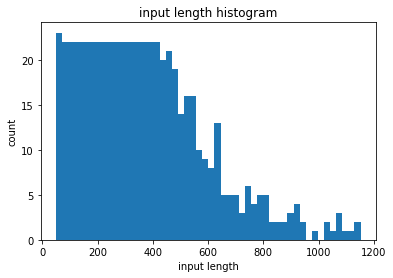

In [22]:
import matplotlib.pyplot as plt
fig = plt.hist(counter, bins=50)
plt.xlabel('input length')
plt.ylabel('count')
plt.title('input length histogram')
plt.savefig('multiinput-length-histogram.png')

,CATALYST,REACTANT,REAGENT,SOLVENT,INTERNAL_STANDARD,NoData,PRODUCT,YIELD,TEMP,input,len
28189,,CC(=O)S[C@@H]1CC2=CC(=O)C=C[C@]2(C)[C@H]2CC[C@...,,,,,CC(C)CN=C1C(c2ccccc2)=C(c2ccccc2)C(c2ccccc2)=C...,,,REACTANT:CC(=O)S[C@@H]1CC2=CC(=O)C=C[C@]2(C)[C...,1076
28194,,CC(C)C(C(=O)OC(C#N)c1cccc(Oc2ccccc2)c1)c1ccc(C...,,,,,CC(C)CN=C1C(c2ccccc2)=C(c2ccccc2)C(c2ccccc2)=C...,,,REACTANT:CC(C)C(C(=O)OC(C#N)c1cccc(Oc2ccccc2)c...,1152
28198,,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...,,,,,CC(C)CN=C1C(c2ccccc2)=C(c2ccccc2)C(c2ccccc2)=C...,,,REACTANT:C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C...,1093
909023,,CC(C)=CO[Si](C)(C)C.CC1=C(/C=C/C(C)=C/C=C/C(C)...,,,,,CCOC(=O)c1cccc(-c2cn(-c3ccc(F)c(F)c3)nc2C(=O)O...,,,REACTANT:CC(C)=CO[Si](C)(C)C.CC1=C(/C=C/C(C)=C...,1137
1309960,,Cc1c(C)c(S(=O)(=O)NC(=N)NCCC[C@H](NC(=O)OCC2c3...,,,,,O=C(O)c1cccc(Cl)c1,,,REACTANT:Cc1c(C)c(S(=O)(=O)NC(=N)NCCC[C@H](NC(...,1037
1347420,,Cc1c(C)c(S(=O)(=O)NC(=N)NCCC[C@H](NC(=O)OCC2c3...,,,,,O=C(O)c1cccc(Cl)c1,,,REACTANT:Cc1c(C)c(S(=O)(=O)NC(=N)NCCC[C@H](NC(...,1037
1354904,,CC(Nc1nc(NC2(C(F)(F)F)CC2)c2nc(-c3ccc(F)cc3)cc...,,,,,O=C(O)c1cccc(Cl)c1,,,REACTANT:CC(Nc1nc(NC2(C(F)(F)F)CC2)c2nc(-c3ccc...,1084
1376301,,CC(=O)N[C@H]1CC[C@H]2[C@@H]3CC[C@H]4C[C@H](O)C...,,,,,O=C(O)c1cccc(Cl)c1,,,REACTANT:CC(=O)N[C@H]1CC[C@H]2[C@@H]3CC[C@H]4C...,1060
1566825,,CC(=O)S[C@@H]1CC2=CC(=O)C=C[C@]2(C)[C@H]2CC[C@...,,,,,CCCCCCCC/C=C\CCCCCCCC(=O)O,,,REACTANT:CC(=O)S[C@@H]1CC2=CC(=O)C=C[C@]2(C)[C...,1076
1566832,,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...,,,,,CCCCCCCC/C=C\CCCCCCCC(=O)O,,,REACTANT:C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C...,1093


In [40]:
df = pd.read_csv('../all_ord_reaction_uniq_with_attr_v3.tsv')
df = df[~df['YIELD'].isna()]
for col in ['CATALYST', 'REACTANT', 'REAGENT', 'SOLVENT', 'INTERNAL_STANDARD', 'NoData','PRODUCT', 'YIELD', 'TEMP']:
    df[col] = df[col].fillna(' ')
# df['input'] = 'REACTANT:' + df['REACTANT'] + 'PRODUCT:' + df['PRODUCT'] + 'CATALYST:' + df['CATALYST'] + 'REAGENT:' + df['REAGENT'] + 'SOLVENT:' + df['SOLVENT'] + 'NoData:' + df['NoData']
df['input'] = 'REACTANT:' + df['REACTANT'] + 'PRODUCT:' + df['PRODUCT'] + 'CATALYST:' + df['CATALYST']
from collections import Counter
df['len'] = df['input'].apply(lambda x: len(x))
counter = Counter()
for l in df['len']:
    counter[l] += 1
counter

/tmp/ipykernel_1464/3848426775.py:1: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../all_ord_reaction_uniq_with_attr_v3.tsv')
/tmp/ipykernel_1464/3848426775.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(' ')


Counter({308: 90,
         309: 102,
         334: 30,
         320: 72,
         313: 76,
         293: 181,
         301: 122,
         302: 113,
         307: 119,
         305: 129,
         319: 66,
         310: 94,
         80: 1929,
         76: 1288,
         86: 3181,
         90: 4184,
         97: 5727,
         82: 2173,
         92: 4607,
         96: 5528,
         103: 7127,
         93: 4996,
         89: 3836,
         99: 6397,
         110: 8010,
         105: 7230,
         101: 6796,
         111: 8387,
         115: 8572,
         122: 8372,
         153: 5091,
         155: 4991,
         151: 5373,
         181: 2395,
         162: 4331,
         177: 2633,
         159: 4443,
         175: 2937,
         161: 4146,
         148: 5919,
         158: 4748,
         176: 2586,
         149: 5707,
         173: 3050,
         57: 63,
         45: 1,
         102: 6820,
         95: 5524,
         147: 5775,
         142: 6785,
         83: 2529,
         133: 7596

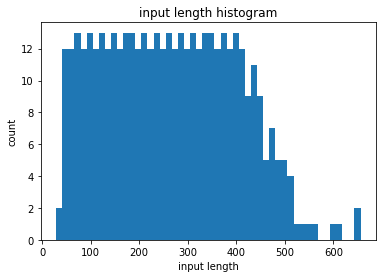

In [43]:
import matplotlib.pyplot as plt
fig = plt.hist(counter, bins=50)
plt.xlabel('input length')
plt.ylabel('count')
plt.title('input length histogram')
plt.savefig('regression-length-histogram.png')

In [42]:
df

,CATALYST,REACTANT,REAGENT,SOLVENT,INTERNAL_STANDARD,NoData,PRODUCT,YIELD,TEMP,input,len
0,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,CC(=O)c1ccc(Br)cc1.O=C(O)C1CCCN1C(=O)OCc1ccccc1,O=C([O-])[O-].[Cs+],CN(C)C=O,,,CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1,93.0,23.0,REACTANT:CC(=O)c1ccc(Br)cc1.O=C(O)C1CCCN1C(=O)...,308
1,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,CC(=O)c1ccc(Br)cc1.CC(C)(C)OC(=O)N1CCCCC1C(=O)O,O=C([O-])[O-].[Cs+],CN(C)C=O,,,CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1,82.0,23.0,REACTANT:CC(=O)c1ccc(Br)cc1.CC(C)(C)OC(=O)N1CC...,308
2,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,CC(=O)c1ccc(Br)cc1.CC(C)(C)OC(=O)N1CCOCC1C(=O)O,O=C([O-])[O-].[Cs+],CN(C)C=O,,,CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1,61.0,23.0,REACTANT:CC(=O)c1ccc(Br)cc1.CC(C)(C)OC(=O)N1CC...,308
3,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,CC(=O)c1ccc(Br)cc1.CC(C)C(NC(=O)OC(C)(C)C)C(=O)O,O=C([O-])[O-].[Cs+],CN(C)C=O,,,CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1,72.0,23.0,REACTANT:CC(=O)c1ccc(Br)cc1.CC(C)C(NC(=O)OC(C)...,309
4,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,CC(=O)c1ccc(Br)cc1.CC(C)(C)OC(=O)NC(Cc1cn(C(=O...,O=C([O-])[O-].[Cs+],CN(C)C=O,,,CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1,83.0,23.0,REACTANT:CC(=O)c1ccc(Br)cc1.CC(C)(C)OC(=O)NC(C...,334
...,...,...,...,...,...,...,...,...,...,...,...
2268493,,CCOC(=O)CCBr.Cl.Fc1ccc2c(C3CCNCC3)nsc2c1.O=C([...,,CC#N.CCOC(C)=O.CCOCC.O,,,CC(O)CC(=O)[O-].O=C([O-])CCCO,64.0,,REACTANT:CCOC(=O)CCBr.Cl.Fc1ccc2c(C3CCNCC3)nsc...,115
2268494,,C1CCOC1.CCOC(=O)CCN1CCC(c2noc3cc(F)ccc23)CC1.C...,,,,,CC(O)CC(=O)[O-].O=C([O-])CCCO,61.0,,REACTANT:C1CCOC1.CCOC(=O)CCN1CCC(c2noc3cc(F)cc...,109
2268495,,CCCCCCCCCC(=O)Cl.CCN(CC)CC.O=C1c2ccccc2C(O)N1C...,,ClCCl,,,CC(O)CC(=O)[O-].O=C([O-])CCCO,83.0,,REACTANT:CCCCCCCCCC(=O)Cl.CCN(CC)CC.O=C1c2cccc...,129
2268496,,CCC(O)(CC)CCN1CCC(c2noc3cc(F)ccc23)CC1.CCCCCCC...,,ClCCl,,,CC(O)CC(=O)[O-].O=C([O-])CCCO,81.0,,REACTANT:CCC(O)(CC)CCN1CCC(c2noc3cc(F)ccc23)CC...,128


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import gc
import random
import itertools
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch
import tokenizers
import transformers
from transformers import AutoTokenizer, EncoderDecoderModel, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
import datasets
from datasets import load_dataset, load_metric
import sentencepiece
import argparse
from datasets.utils.logging import disable_progress_bar
from rdkit import Chem
import rdkit
disable_progress_bar()

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--input_data", type=str, required=False)
#     parser.add_argument("--dataset_name", type=str, required=False)
    parser.add_argument("--model_name_or_path", type=str, required=True)
    parser.add_argument("--model", type=str, required=True)
    parser.add_argument("--debug", action='store_true', default=False, required=False)
    parser.add_argument("--num_beams", type=int, default=5, required=False)
    parser.add_argument("--num_return_sequences", type=int, default=5, required=False)
    parser.add_argument("--seed", type=int, default=42, required=False)

    return parser.parse_args()
    
# CFG = parse_args()

class CFG:
    model = 't5'
    dataset_path = '../../multi-input-valid.csv'
    model_name_or_path = '/data2/sagawa/tcrp-multiinput-archive/10-epoch-archive2/t5/checkpoint-2721180'
    num_beams = 5
    num_return_sequences = 5
    debug = True
    seed = 42
    

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(seed=CFG.seed)  
    

    
dataset = pd.read_csv(CFG.dataset_path)



tokenizer = AutoTokenizer.from_pretrained(CFG.model_name_or_path, return_tensors='pt')
from transformers import AutoTokenizer, AutoConfig, AutoModel, T5EncoderModel
model = T5EncoderModel.from_pretrained(CFG.model_name_or_path)

Some weights of the model checkpoint at /data2/sagawa/tcrp-multiinput-archive/10-epoch-archive2/t5/checkpoint-2721180 were not used when initializing T5EncoderModel: ['decoder.block.2.layer.0.SelfAttention.q.weight', 'decoder.block.4.layer.1.EncDecAttention.o.weight', 'decoder.block.10.layer.0.SelfAttention.k.weight', 'decoder.block.9.layer.0.SelfAttention.v.weight', 'decoder.block.3.layer.1.layer_norm.weight', 'decoder.block.7.layer.0.SelfAttention.v.weight', 'decoder.block.9.layer.1.EncDecAttention.o.weight', 'decoder.block.2.layer.1.EncDecAttention.o.weight', 'decoder.block.3.layer.1.EncDecAttention.k.weight', 'decoder.block.10.layer.2.DenseReluDense.wo.weight', 'decoder.block.2.layer.2.DenseReluDense.wi_0.weight', 'decoder.block.1.layer.0.layer_norm.weight', 'decoder.block.7.layer.0.SelfAttention.o.weight', 'decoder.block.8.layer.2.DenseReluDense.wo.weight', 'decoder.block.5.layer.0.SelfAttention.k.weight', 'decoder.block.4.layer.1.EncDecAttention.k.weight', 'decoder.block.6.layer.

In [9]:
a = pd.read_csv('../../all_ord_reaction_uniq_with_attr_v3.tsv')
a

,CATALYST,REACTANT,REAGENT,SOLVENT,INTERNAL_STANDARD,NoData,PRODUCT,YIELD,TEMP
0,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,CC(=O)c1ccc(Br)cc1.O=C(O)C1CCCN1C(=O)OCc1ccccc1,O=C([O-])[O-].[Cs+],CN(C)C=O,NaN,NaN,CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1,93.0,23.0
1,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,CC(=O)c1ccc(Br)cc1.CC(C)(C)OC(=O)N1CCCCC1C(=O)O,O=C([O-])[O-].[Cs+],CN(C)C=O,NaN,NaN,CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1,82.0,23.0
2,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,CC(=O)c1ccc(Br)cc1.CC(C)(C)OC(=O)N1CCOCC1C(=O)O,O=C([O-])[O-].[Cs+],CN(C)C=O,NaN,NaN,CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1,61.0,23.0
3,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,CC(=O)c1ccc(Br)cc1.CC(C)C(NC(=O)OC(C)(C)C)C(=O)O,O=C([O-])[O-].[Cs+],CN(C)C=O,NaN,NaN,CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1,72.0,23.0
4,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,CC(=O)c1ccc(Br)cc1.CC(C)(C)OC(=O)NC(Cc1cn(C(=O...,O=C([O-])[O-].[Cs+],CN(C)C=O,NaN,NaN,CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1,83.0,23.0
...,...,...,...,...,...,...,...,...,...
2268539,NaN,CN1CCCC1=O.COc1cc(C(=O)CO)ccc1OCCCCl.Fc1ccc2c(...,NaN,O,NaN,NaN,CC(O)CC(=O)[O-].O=C([O-])CCCO,NaN,100.0
2268540,NaN,CC(O)=S.CCOC(=O)N=NC(=O)OCC.O=C1C[C@@H](O)CN1....,NaN,C1CCOC1,NaN,NaN,CC(O)CC(=O)[O-].O=C([O-])CCCO,NaN,NaN
2268541,NaN,C[C@@H](O[Si](C)(C)C(C)(C)C)[C@H]1C(=O)N2C(C(=...,NaN,CC#N,NaN,NaN,CC(O)CC(=O)[O-].O=C([O-])CCCO,NaN,NaN
2268542,CC(=O)[O-].O.[Cu+2],C=O.CC(=O)O.CC(=O)[O-].CCOC(=O)CC(=O)OCC.[K+],NaN,NaN,NaN,NaN,O=S(=O)(c1ccc(Cl)cc1)C(F)(F)F,NaN,NaN


440212

In [14]:
# outputs = []
# for input_data in dataset['input'][:5000]:
#     inp = tokenizer(input_data, return_tensors='pt', max_length=512, padding='max_length', truncation=True).to(device)
#     output = model(**inp)
# #     output[0][0].shape => torch.Size([512, 768])
#     outputs.append(output[0][0].detach().numpy())

outputs = []
for input_data in dataset['input'][:5000]:
    inp = tokenizer(input_data, return_tensors='pt', max_length=512, padding='max_length', truncation=True).to(device)
    output = model(**inp)
#     output[0][0].shape => torch.Size([512, 768])
    outputs.append(output[0][:, 0, :].detach().numpy())

In [18]:
type(outputs[0].shape)

tuple

In [19]:
np.save('embedding_5000.npy', outputs)

In [21]:
outputs = np.load('embedding_5000.npy')
outputs = outputs[:, 0, :]
outputs.shape

(5000, 768)

In [4]:
dist_matrix = np.zeros([len(outputs),len(outputs)])

for i in range(len(outputs)):
    for j in range(len(outputs)):
        dist = np.linalg.norm(outputs[i] - outputs[j])
        dist_matrix[i][j] = dist

In [2]:
# np.save('distance_5000.npy', dist_matrix)
dist_matrix = np.load('distance_5000.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'distance_5000.npy'

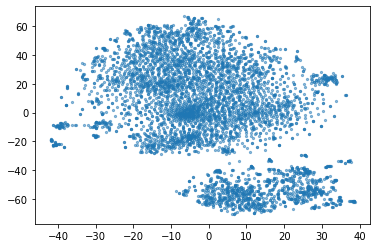

In [30]:
# from sklearn.manifold import TSNE, MDS
# tsne = TSNE(n_components=2, random_state=42, metric='precomputed')
# tsne_out = tsne.fit_transform(dist_matrix)
import matplotlib.pyplot as plt
plt.scatter(tsne_out[:, 0], tsne_out[:, 1], alpha=0.5, s=5)

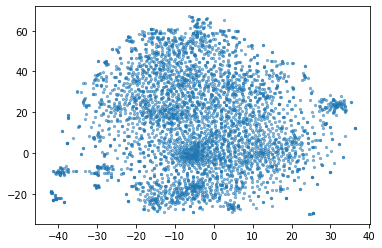

In [31]:
plt.scatter(tsne_out[tsne_out[:, 1]>-30][:, 0], tsne_out[tsne_out[:, 1]>-30][:, 1], alpha=0.5, s=5)

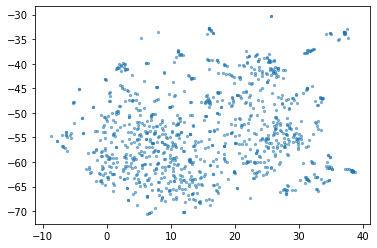

In [32]:
plt.scatter(tsne_out[tsne_out[:, 1]<-30][:, 0], tsne_out[tsne_out[:, 1]<-30][:, 1], alpha=0.5, s=5)

In [35]:
upper = dataset[:5000][out[:, 1]>-30]
upper

ValueError: Item wrong length 3937 instead of 5000.

In [25]:
lower = dataset[:5000][out[:, 1]<-30]
lower

,input,PRODUCT
1,REACTANT: CATALYST: REAGENT: SOLVENT: NoData:C...,CC(C)(C)OC(=O)NC1(C2CCNC2)CCC1
3,REACTANT: CATALYST: REAGENT: SOLVENT: NoData:C...,CCCC(Cc1ccc(OCCN2CCCCCC2)cc1)(C(=O)O)S(=O)(=O)...
6,REACTANT: CATALYST: REAGENT: SOLVENT: NoData:C...,COCCOCc1ccc(O)cc1
11,REACTANT: CATALYST: REAGENT: SOLVENT: NoData:C...,Cc1ccsc1C(=O)NCCCSc1ccncc1
14,REACTANT: CATALYST: REAGENT: SOLVENT: NoData:C...,CC(=O)OCc1c(-c2cc([Si](C)(C)C)c(=O)n(C)n2)cccc...
...,...,...
4983,REACTANT: CATALYST: REAGENT: SOLVENT: NoData:O...,O=C(Cl)c1ccc(OCc2ccccc2)cc1
4985,REACTANT: CATALYST: REAGENT: SOLVENT: NoData:C...,CNCCC#Cc1cccnc1
4992,REACTANT: CATALYST: REAGENT: SOLVENT: NoData:C...,COc1ccc(-n2nc(C(=O)O)cc2-c2ccc(SC)cc2)cc1
4993,REACTANT: CATALYST: REAGENT: SOLVENT: NoData:C...,CC1(C)C(C(=O)c2cn(CCCCN)c3ccccc23)C1(C)C


In [45]:
tf = [True if i.startswith('REACTANT: CATALYST: REAGENT: SOLVENT: NoData:') else False for i in lower['input']]
print(sum(tf)/len(tf))

0.9990592662276576


In [49]:
tf = [True if i.startswith('REACTANT: CATALYST: REAGENT: SOLVENT: NoData:') else False for i in upper['input']]
print(sum(tf)/len(tf))

0.002032004064008128


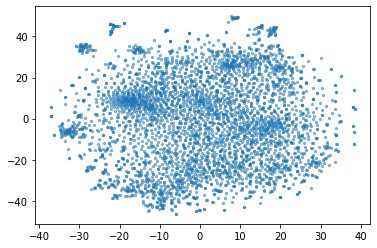

In [34]:
from umap import UMAP
# Apply the singular value decomposition
tsne = TSNE(n_components=2, random_state=42, metric='precomputed') # 512
out_up = tsne.fit_transform(dist_matrix[tsne_out[:, 1]>-30, :][:, tsne_out[:, 1]>-30])
import matplotlib.pyplot as plt
plt.scatter(out_up[:, 0], out_up[:, 1], alpha=0.5, s=5)

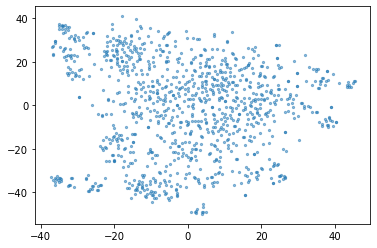

In [33]:
from umap import UMAP
# Apply the singular value decomposition
tsne = TSNE(n_components=2, random_state=42, metric='precomputed') # 512
out_down = tsne.fit_transform(dist_matrix[tsne_out[:, 1]<-30, :][:, tsne_out[:, 1]<-30])
import matplotlib.pyplot as plt
plt.scatter(out_down[:, 0], out_down[:, 1], alpha=0.5, s=5)

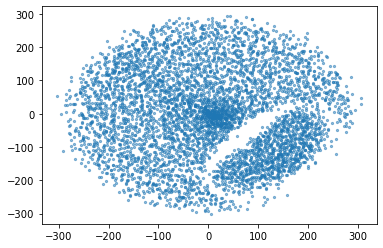

In [36]:
mds = MDS(n_components=2, random_state=42, dissimilarity='precomputed')
out_mds = mds.fit_transform(dist_matrix)
plt.scatter(out_mds[:, 0], out_mds[:, 1], alpha=0.5, s=5)

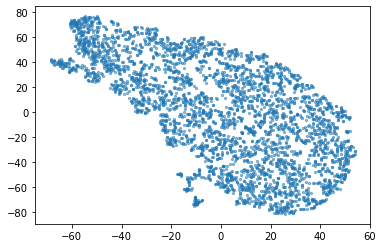

In [38]:
# tsne = TSNE(n_components=2, random_state=42)
# out_tsne2 = tsne.fit_transform(dist_matrix[tsne_out[:, 1]>-30, :][:, tsne_out[:, 1]>-30])
plt.scatter(out_tsne2[:, 0], out_tsne2[:, 1], alpha=0.5, s=5)

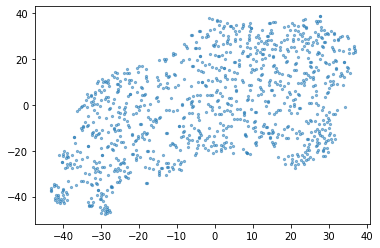

In [39]:
tsne = TSNE(n_components=2, random_state=42)
out_tsne2 = tsne.fit_transform(dist_matrix[tsne_out[:, 1]<-30, :][:, tsne_out[:, 1]<-30])
plt.scatter(out_tsne2[:, 0], out_tsne2[:, 1], alpha=0.5, s=5)

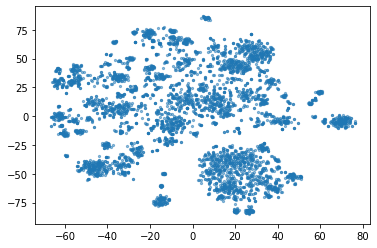

In [29]:
# cls
from sklearn.manifold import TSNE, MDS
tsne = TSNE(n_components=2, random_state=42)
tsne_out = tsne.fit_transform(outputs)
import matplotlib.pyplot as plt
plt.scatter(tsne_out[:, 0], tsne_out[:, 1], alpha=0.5, s=5)

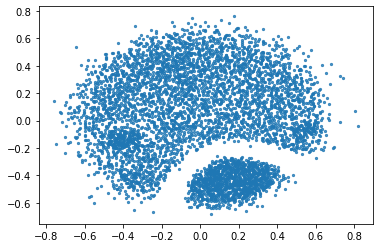

In [26]:
# cls
from sklearn.manifold import TSNE, MDS
tsne = MDS(n_components=2, random_state=42)
mds_out = tsne.fit_transform(outputs)
import matplotlib.pyplot as plt
plt.scatter(mds_out[:, 0], mds_out[:, 1], alpha=0.8, s=5)

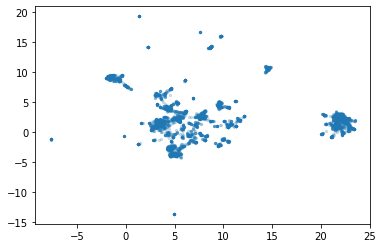

In [31]:
# cls
from umap import UMAP
umap = UMAP(n_components=2, random_state=42)
umap_out = umap.fit_transform(outputs)
plt.scatter(umap_out[:, 0], umap_out[:, 1], alpha=0.2, s=5)

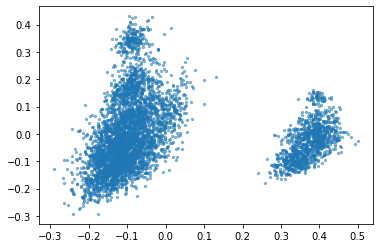

In [32]:
# cls
from sklearn.decomposition import PCA, TruncatedSVD
umap = PCA(n_components=2, random_state=42)
pca_out = umap.fit_transform(outputs)
plt.scatter(pca_out[:, 0], pca_out[:, 1], alpha=0.5, s=5)

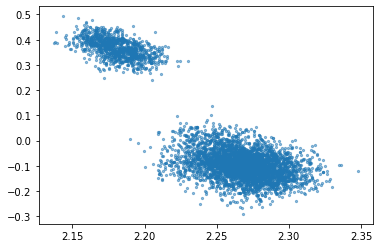

In [33]:
# cls
from sklearn.decomposition import PCA, TruncatedSVD
umap = TruncatedSVD(n_components=2, random_state=42)
svd_out = umap.fit_transform(outputs)
plt.scatter(svd_out[:, 0], svd_out[:, 1], alpha=0.5, s=5)

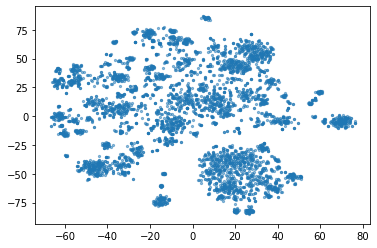

In [34]:
# # cls
# from sklearn.manifold import TSNE, MDS
# tsne = TSNE(n_components=2, random_state=42)
# tsne_out = tsne.fit_transform(outputs)
# import matplotlib.pyplot as plt
plt.scatter(tsne_out[:, 0], tsne_out[:, 1], alpha=0.5, s=5)

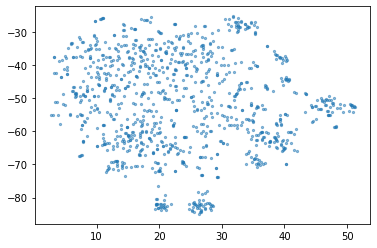

In [37]:
plt.scatter(tsne_out[(tsne_out[:, 0] > 0) & (tsne_out[:, 1] < -25)][:, 0], tsne_out[(tsne_out[:, 0] > 0) & (tsne_out[:, 1] < -25)][:, 1], alpha=0.5, s=5)

In [40]:
sum((tsne_out[:, 0] > 0) & (tsne_out[:, 1] < -25))

1062

In [41]:
sum((tsne_out[:, 0] <= 0) | (tsne_out[:, 1] >= -25))

3938

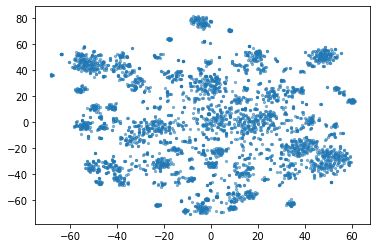

In [42]:
# cls
from sklearn.manifold import TSNE, MDS
tsne = TSNE(n_components=2, random_state=42)
tsne_out = tsne.fit_transform(outputs[(tsne_out[:, 0] <= 0) | (tsne_out[:, 1] >= -25)])
import matplotlib.pyplot as plt
plt.scatter(tsne_out[:, 0], tsne_out[:, 1], alpha=0.5, s=5)

In [57]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42).fit(tsne_out)
labels = kmeans.labels_

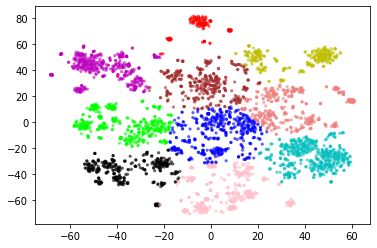

In [62]:
cd = {0:'r', 1:'b', 2:'m', 3:'y', 4:'c', 5:'k', 6:'brown', 7:'pink', 8:'lime', 9:'lightcoral'}
color = [cd[l] for l in labels]
plt.scatter(tsne_out[:, 0], tsne_out[:, 1], alpha=0.5, s=5, color=color)

In [29]:
df['YIELD'].quantile(0.999)

110.0

In [21]:
df = pd.read_csv('../../all_ord_reaction_uniq_with_attr_v3.tsv')
print(len(df['PRODUCT'].unique()))

440212


In [20]:
df = df[~df['REACTANT'].isna()]
print(len(df['PRODUCT'].unique()))

447


In [25]:
df[(df['REACTANT'].isna()) & (~df['NoData'].isna())]

,CATALYST,REACTANT,REAGENT,SOLVENT,INTERNAL_STANDARD,NoData,PRODUCT,YIELD,TEMP
73855,NaN,NaN,NaN,NaN,NaN,C1CCOC1.CC(C)C[Mg+].CON(C)C(=O)c1ccc(O)nc1.[Cl-],CC(C)CC(=O)c1ccc(O)nc1,NaN,NaN
73856,NaN,NaN,NaN,NaN,NaN,CN.O.O=C(O)c1ccc(Cl)c([N+](=O)[O-])c1,CNc1ccc(C(=O)O)cc1[N+](=O)[O-],NaN,NaN
73857,NaN,NaN,NaN,NaN,NaN,CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(N)cc3)cc21....,CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(NC=O)cc3)cc21,NaN,NaN
73858,NaN,NaN,NaN,NaN,NaN,CC(C)=C(Cl)N(C)C.COCC(C)Oc1cc(Oc2cnc(C(=O)N3CC...,COCC(C)Oc1cc(Oc2cnc(C(=O)N3CCC3)cn2)cc(C(=O)Nc...,NaN,NaN
73859,NaN,NaN,NaN,NaN,NaN,Clc1cc2c(Cl)nc(-c3ccncc3)nc2s1.NCc1ccc(Cl)c(Cl)c1,Clc1cc2c(NCc3ccc(Cl)c(Cl)c3)nc(-c3ccncc3)nc2s1,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2051384,NaN,NaN,NaN,NaN,NaN,CCN1CC2OC2C1.CCOc1ccccc1O.Cl.ClCCl,CCOc1ccccc1OC1CN(CC)CC1O,NaN,NaN
2051385,NaN,NaN,NaN,NaN,NaN,CC(=O)O.CCOC(=O)C(=Cc1cccc(OCCc2ccc(OS(C)(=O)=...,CCOC(=O)C(Cc1cccc(OCCc2ccc(OS(C)(=O)=O)cc2)c1)OCC,NaN,NaN
2051386,NaN,NaN,NaN,NaN,NaN,CCCCC1CCNCC1.Cc1ccc(S(=O)(=O)OCC(C)Cn2c(=O)sc3...,CCCCC1CCN(CC(C)Cn2c(=O)sc3ccccc32)CC1,NaN,NaN
2051387,NaN,NaN,NaN,NaN,NaN,CC(C)I.CN(C)C=O.COC(=O)c1cc(Br)cc2[nH]ccc12.O....,COC(=O)c1cc(Br)cc2c1ccn2C(C)C,NaN,NaN


In [24]:
df

,CATALYST,REACTANT,REAGENT,SOLVENT,INTERNAL_STANDARD,NoData,PRODUCT,YIELD,TEMP
0,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,CC(=O)c1ccc(Br)cc1.O=C(O)C1CCCN1C(=O)OCc1ccccc1,O=C([O-])[O-].[Cs+],CN(C)C=O,NaN,NaN,CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1,93.0,23.0
1,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,CC(=O)c1ccc(Br)cc1.CC(C)(C)OC(=O)N1CCCCC1C(=O)O,O=C([O-])[O-].[Cs+],CN(C)C=O,NaN,NaN,CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1,82.0,23.0
2,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,CC(=O)c1ccc(Br)cc1.CC(C)(C)OC(=O)N1CCOCC1C(=O)O,O=C([O-])[O-].[Cs+],CN(C)C=O,NaN,NaN,CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1,61.0,23.0
3,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,CC(=O)c1ccc(Br)cc1.CC(C)C(NC(=O)OC(C)(C)C)C(=O)O,O=C([O-])[O-].[Cs+],CN(C)C=O,NaN,NaN,CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1,72.0,23.0
4,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,CC(=O)c1ccc(Br)cc1.CC(C)(C)OC(=O)NC(Cc1cn(C(=O...,O=C([O-])[O-].[Cs+],CN(C)C=O,NaN,NaN,CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1,83.0,23.0
...,...,...,...,...,...,...,...,...,...
2268539,NaN,CN1CCCC1=O.COc1cc(C(=O)CO)ccc1OCCCCl.Fc1ccc2c(...,NaN,O,NaN,NaN,CC(O)CC(=O)[O-].O=C([O-])CCCO,NaN,100.0
2268540,NaN,CC(O)=S.CCOC(=O)N=NC(=O)OCC.O=C1C[C@@H](O)CN1....,NaN,C1CCOC1,NaN,NaN,CC(O)CC(=O)[O-].O=C([O-])CCCO,NaN,NaN
2268541,NaN,C[C@@H](O[Si](C)(C)C(C)(C)C)[C@H]1C(=O)N2C(C(=...,NaN,CC#N,NaN,NaN,CC(O)CC(=O)[O-].O=C([O-])CCCO,NaN,NaN
2268542,CC(=O)[O-].O.[Cu+2],C=O.CC(=O)O.CC(=O)[O-].CCOC(=O)CC(=O)OCC.[K+],NaN,NaN,NaN,NaN,O=S(=O)(c1ccc(Cl)cc1)C(F)(F)F,NaN,NaN


In [27]:

df = pd.read_csv('../../all_ord_reaction_uniq_with_attr_v3.tsv')
df = df[df['YIELD'] <= 100]

In [4]:
from sklearn.metrics import mean_squared_error, r2_score
print(mean_squared_error(df['YIELD'], df['prediction'], squared=False), r2_score(df['YIELD'], df['prediction']))

25.519197441039037 0.19086268719109778


In [12]:
print(mean_squared_error(df['YIELD'], df['prediction'].clip(0), squared=False), r2_score(df['YIELD'], df['prediction'].clip(0)))

25.512149509076302 0.1913095630966486


In [16]:
print(mean_squared_error(df['YIELD'], df['prediction'].clip(0, 100), squared=False), r2_score(df['YIELD'], df['prediction'].clip(0, 100)))

25.507387811072732 0.1916114098915006


In [17]:
print(mean_squared_error(df['YIELD'].clip(0, 100), df['prediction'].clip(0, 100), squared=False), r2_score(df['YIELD'].clip(0, 100), df['prediction'].clip(0, 100)))

23.01815853078627 0.22476314184270274


In [25]:
df['prediction'].min(), df['prediction'].max()

(-20.780594, 113.22212)

In [26]:
df['YIELD'].min(), df['YIELD'].clip(0).max()

(0.0, 99.0)

,CATALYST,REACTANT,REAGENT,SOLVENT,INTERNAL_STANDARD,NoData,PRODUCT,YIELD,TEMP,input,prediction
555,,C#Cc1cccc(C2(NCC(O)C(Cc3cc(F)cc(F)c3)NC(=O)OC(...,,,,,O=S(=O)([O-])[O-].O=S(=O)([O-])[O-].O=S(=O)([O...,106.0,,REACTANT:C#Cc1cccc(C2(NCC(O)C(Cc3cc(F)cc(F)c3)...,64.638600
673,,C1CCNCC1.CCOC(OCC)[C@H](C)N(Cc1csc2ccc(Cl)nc12...,,,,,c1ccc2sc(-c3nccc4ccccc34)cc2c1,119.0,,REACTANT:C1CCNCC1.CCOC(OCC)[C@H](C)N(Cc1csc2cc...,73.549220
967,,COC(=O)C(CNCC(F)(F)F)c1ccc(Cl)cc1.C[Si](C)(C)O[K],,C1CCOC1.CCOCC,,,c1ccc2sc(-c3nccc4ccccc34)cc2c1,118.0,,REACTANT:COC(=O)C(CNCC(F)(F)F)c1ccc(Cl)cc1.C[S...,86.737630
1143,,CC(=O)N1CCOCC1.CC(C)[N-]C(C)C.COC(=O)c1scc(Br)...,,C1CCOC1,,,O=C(O)c1cccc(Cl)c1,138.0,0.0,REACTANT:CC(=O)N1CCOCC1.CC(C)[N-]C(C)C.COC(=O)...,65.063070
1261,,CCCCOCc1ccc(C#N)cc1.N.[Al+3].[H-].[Li+],,C1CCOC1,,,Cc1cc(Cc2cc(C)c(O)c(C=O)c2)cc(C=O)c1O,101.0,,REACTANT:CCCCOCc1ccc(C#N)cc1.N.[Al+3].[H-].[Li...,78.941440
...,...,...,...,...,...,...,...,...,...,...,...
67635,,Nc1ccncc1.O=C(Cl)Oc1ccccc1,,,,,c1ccc2sc(-c3nccc4ccccc34)cc2c1,534.0,,REACTANT:Nc1ccncc1.O=C(Cl)Oc1ccccc1PRODUCT:c1c...,60.926212
67803,,O=C(OO)c1cccc(Cl)c1.c1cnc2[nH]ccc2c1,,CCOCC,,,O=C(O)c1cccc(Cl)c1,125.0,,REACTANT:O=C(OO)c1cccc(Cl)c1.c1cnc2[nH]ccc2c1P...,70.931320
67884,,O=[N+]([O-])c1cc(F)c(F)c(F)c1.Oc1ccc(F)cc1,,CN(C)C=O,,,CNC(=O)c1ncn2c(C)cc(C)[n+](C)c12.[Cl-],105.0,,REACTANT:O=[N+]([O-])c1cc(F)c(F)c(F)c1.Oc1ccc(...,78.260000
67995,,CC(C)(C)OC(=O)NNC1CCCN(Cc2ccccc2)C1.Cl,,,,,O=C(O)c1cccc(Cl)c1,112.0,,REACTANT:CC(C)(C)OC(=O)NNC1CCCN(Cc2ccccc2)C1.C...,87.196810


In [28]:
from sklearn.metrics import mean_squared_error, r2_score
print(mean_squared_error(df['YIELD'], df['prediction'], squared=False), r2_score(df['YIELD'], df['prediction']))

22.99412361655959 0.2244167382320139


In [29]:
print(mean_squared_error(df['YIELD'], df['prediction'].clip(0), squared=False), r2_score(df['YIELD'], df['prediction'].clip(0)))

22.98627915689757 0.2249458293969845


In [30]:
print(mean_squared_error(df['YIELD'], df['prediction'].clip(0, 100), squared=False), r2_score(df['YIELD'], df['prediction'].clip(0, 100)))

22.98099079506296 0.22530241563472198


In [ ]:
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--data", type=str, required=False)
#     parser.add_argument("--dataset_name", type=str, required=False)
    parser.add_argument("--pretrained_model_name_or_path", type=str, default="sagawa/ZINC-t5", required=False)
    parser.add_argument("--model", type=str, default="t5", required=False)
    parser.add_argument("--model_name_or_path", type=str, required=False)
#     parser.add_argument("--scaler_path", type=str, default="/data2/sagawa/tcrp-regression-model-archive/10-23-1st-new-metric-reactant-product", required=False)
    parser.add_argument("--debug", action='store_true', default=False, required=False)
    parser.add_argument("--max_len", type=int, default=512, required=False)
    parser.add_argument("--batch_size", type=int, default=5, required=False)
    parser.add_argument("--fc_dropout", type=float, default=0.1, required=False)
    parser.add_argument("--num_workers", type=int, default=1, required=False)
    parser.add_argument("--output_dir", type=str, default='./', required=False)
    parser.add_argument("--seed", type=int, default=42, required=False)

    return parser.parse_args()

test_ds = pd.DataFrame.from_dict({'input': CFG.data}, orient='index').T
test_dataset = TestDataset(CFG, test_ds)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1, pin_memory=True, drop_last=False)

prediction = inference_fn(test_loader, model, device)
print('yiled: ', prediction[0][0]*100)
    
    
    
